# Global Sensitivity analysis

To investigate the uncertainty in and the influence of the choice of parameter values we conducted a global sensitivity analysis (see for example Saltelli et al., 2005).Although, there are several methods of global sensitivity analysis suited for different models, we chose a Latin Hypercube (LH) sampling approach coupled to the calculation of the Partial Rank Correlation Coefficient (PRCC) as described in Marino et al., 2008. We chose this method for its robustness and simplicity. For the LH sampling we used the Python package pyDOE version 0.3.8. For each parameter, the LH sample was transformed to a suitable uniform distribution. The combined parameter distribution was sampled 1000 times and the model was simulated with the new parameters. Using the steady-state output of the compounds and the fluxes the PRCC for each parameter was calculated. 

## References

- Saltelli, A., Ratto, M., Tarantola, S., and Campolongo, F. (2005). Sensitivity analysis for chemical models.352Chemical reviews 105, 2811–2828
- Marino, S., Hogue, I. B., Ray, C. J., and Kirschner, D. E. (2008). A methodology for performing global uncertainty and sensitivity analysis in systems biology.Journal of theoretical biology 254, 178–196

In [1]:
import modelbase
from modelbase.ode import Simulator
from modelbase.utils.plotting import heatmap_from_dataframe

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import TwoSlopeNorm
from pyDOE import lhs
from scipy import stats
from scipy.stats.distributions import uniform
from sklearn import linear_model
from tqdm.notebook import tqdm
from typing import Optional
from concurrent import futures
from pathlib import Path

plt.style.use("./notebook.mplstyle")
print(modelbase.__version__)


def get_new_y0(s: Simulator) -> dict[str, float]:
    return dict(s.get_results_df().iloc[-1])

1.3.9


In [2]:
%%capture
cd ..

In [3]:
from models import get_model

In [4]:
%%capture

cd analyses-paper/

# Initialise model

In [5]:
y0 = {
    "PQ": 11.027139850905353,
    "PC": 1.8895071932002812,
    "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,
    "NADPH": 0.4882103700673736,
    "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,
    "Psbs": 0.9607146039898598,
    "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,
    "BPGA": 0.0005355311557548053,
    "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,
    "FBP": 0.006126990841013743,
    "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,
    "G1P": 0.041575582577936025,
    "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,
    "E4P": 0.00732079113061801,
    "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,
    "RUBP": 0.13153657267999222,
    "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,
    "ASC": 9.999994138785292,
    "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,
    "GSH": 9.999999991725186,
    "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}

s = Simulator(get_model())
s.initialise(y0)

## Latin hyperspace sampling

In [6]:
parameter_names = [
    "k_ex_atp",
    "k_ex_nadph",
    "thioredoxin_tot",
    "k_fd_tr_reductase",
    "e_cbb_tot",
    "k_e_cbb_activation",
    "k_e_cbb_relaxation",
    "kMehler",
    "kcyc",
    "V1_base",
    "V6_base",
    "V9_base",
    "kcat_DHAR",
    "kcatMDAR",
]

parameter_names_translated = [
    "k_ex_atp",
    "k_ex_nadph",
    "thioredoxin_tot",
    "k_fd_tr_reductase",
    "e_cbb_tot",
    "k_e_cbb_activation",
    "k_e_cbb_relaxation",
    "kMehler",
    "kcyc",
    "kRuBisCO",
    "kFBPase",
    "kSBPase",
    "kDHAR",
    "kMDAR",
]

### Uniform distribution

In [7]:
design = lhs(len(parameter_names), samples=1000)
loc = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
scale = [1, 1, 10, 10, 60, 10, 10, 10, 10, 30, 20, 3, 1400, 3000]

# scale design
for i in range(len(parameter_names)):
    design[:, i] = uniform(loc=loc[i], scale=scale[i]).ppf(
        design[:, i]
    )

design_matrix = []
for j in range(len(design)):
    design_matrix.append(dict(zip(parameter_names, design[j, :])))
design_matrix = pd.DataFrame(design_matrix)

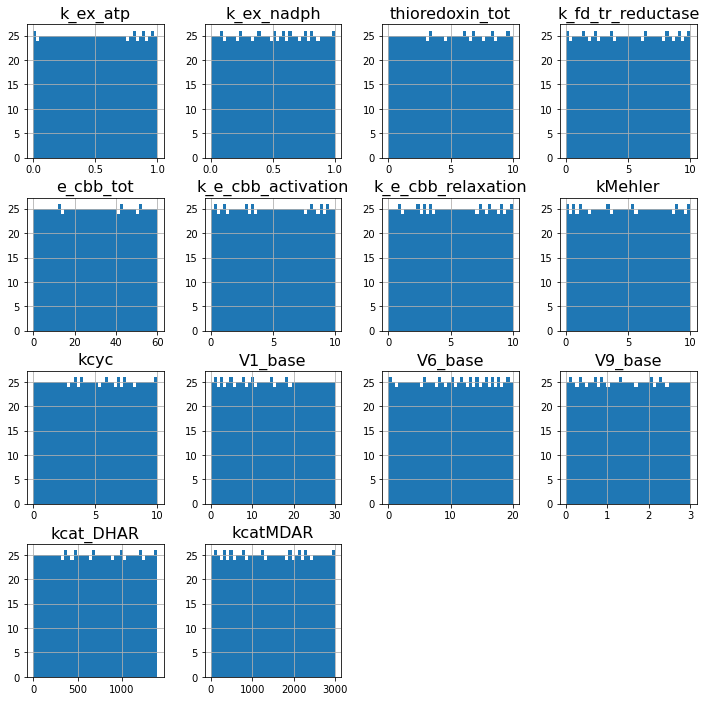

In [8]:
# Check distributions
design_matrix.hist(bins=40, figsize=(12, 12))
plt.show()

# Global Sensitivity Analysis

Partial Rank Correlation Coeffecient

In [ ]:
def PRCC(
    design_matrix: pd.DataFrame, output_matrix: pd.DataFrame, output_variable: str
) -> dict[str, pd.DataFrame]:
    """Partial Rank Correlation Coefficient.
    Returns pandas.DataFrame object

    Parameters
    ----------
    design_matrix:   LHS design matrix. Transformed to desired distribution
    output_matrix:   output of model after changing parameters according to the design matrix
    """
    PCRR_main_dict = {}
    d_names = design_matrix.columns
    design_matrix_ranked = design_matrix.rank()
    output_matrix_ranked = output_matrix.rank()
    for i in d_names:
        PCRR_dict = {}
        X = design_matrix_ranked.drop(i, axis=1)
        y = design_matrix_ranked[i]
        y2 = output_matrix_ranked[output_variable]

        lm = linear_model.LinearRegression()
        model = lm.fit(X, y)
        prediction = model.predict(X)
        residual = y - prediction

        lm = linear_model.LinearRegression()
        model = lm.fit(X, y2)
        prediction = model.predict(X)
        residual2 = y2 - prediction

        r, p_val = stats.pearsonr(residual2, residual)
        PCRR_dict["r"] = r
        PCRR_dict["p_val"] = p_val
        PCRR_dict["residual_design"] = residual
        PCRR_dict["residual_out"] = residual2
        PCRR_main_dict[i] = PCRR_dict
    return PCRR_main_dict


def get_steady_state(
    parameter_values: dict[str, float]
) -> Optional[tuple[dict[str, float], dict[str, float], dict[str, float]]]:
    s = Simulator(get_model())
    s.update_parameter("pfd", 1000)
    s.initialise(y0)
    s.update_parameters(parameter_values)
    t, y = s.simulate_to_steady_state()
    if y is not None:
        return parameter_values, s.get_full_results_dict(), s.get_fluxes_dict()

In [9]:
paths = [
    "design_matrix.csv",
    "concentrations.csv",
    "fluxes.csv",
]
if all(Path(path).exists() for path in paths):
    design_matrix = pd.read_csv("design_matrix.csv", index_col=0)
    concentrations = pd.read_csv("concentrations.csv", index_col=0)
    fluxes = pd.read_csv("fluxes.csv", index_col=0)
else:
    parameter_values = design_matrix.T.to_dict().values()
    with tqdm(total=len(parameter_values)) as pbar:
        with futures.ProcessPoolExecutor() as executor:
            p = []
            c = []
            v = []
            for task in futures.as_completed(
                (executor.submit(get_steady_state, i) for i in parameter_values)
            ):
                if (res := task.result()) is not None:
                    p.append(res[0])
                    c.append(res[1])
                    v.append(res[2])
                pbar.update(1)

    design_matrix = pd.DataFrame(p, dtype=float)
    concentrations = pd.DataFrame(c, dtype=float)
    fluxes = pd.DataFrame(v, dtype=float)

    with open("design_matrix.csv", "w") as f:
        design_matrix.to_csv(f)
    with open("concentrations.csv", "w") as f:
        concentrations.to_csv(f)
    with open("fluxes.csv", "w") as f:
        fluxes.to_csv(f)

compound_prcc = pd.DataFrame(
    {
        name: pd.DataFrame(PRCC(design_matrix, concentrations, name)).loc["r"]
        for name in concentrations.columns
    },
    dtype=float,
)

flux_prcc = pd.DataFrame(
    {
        name: pd.DataFrame(PRCC(design_matrix, fluxes, name)).loc["r"]
        for name in fluxes.columns
    },
    dtype=float,
)

## Heatmap plot

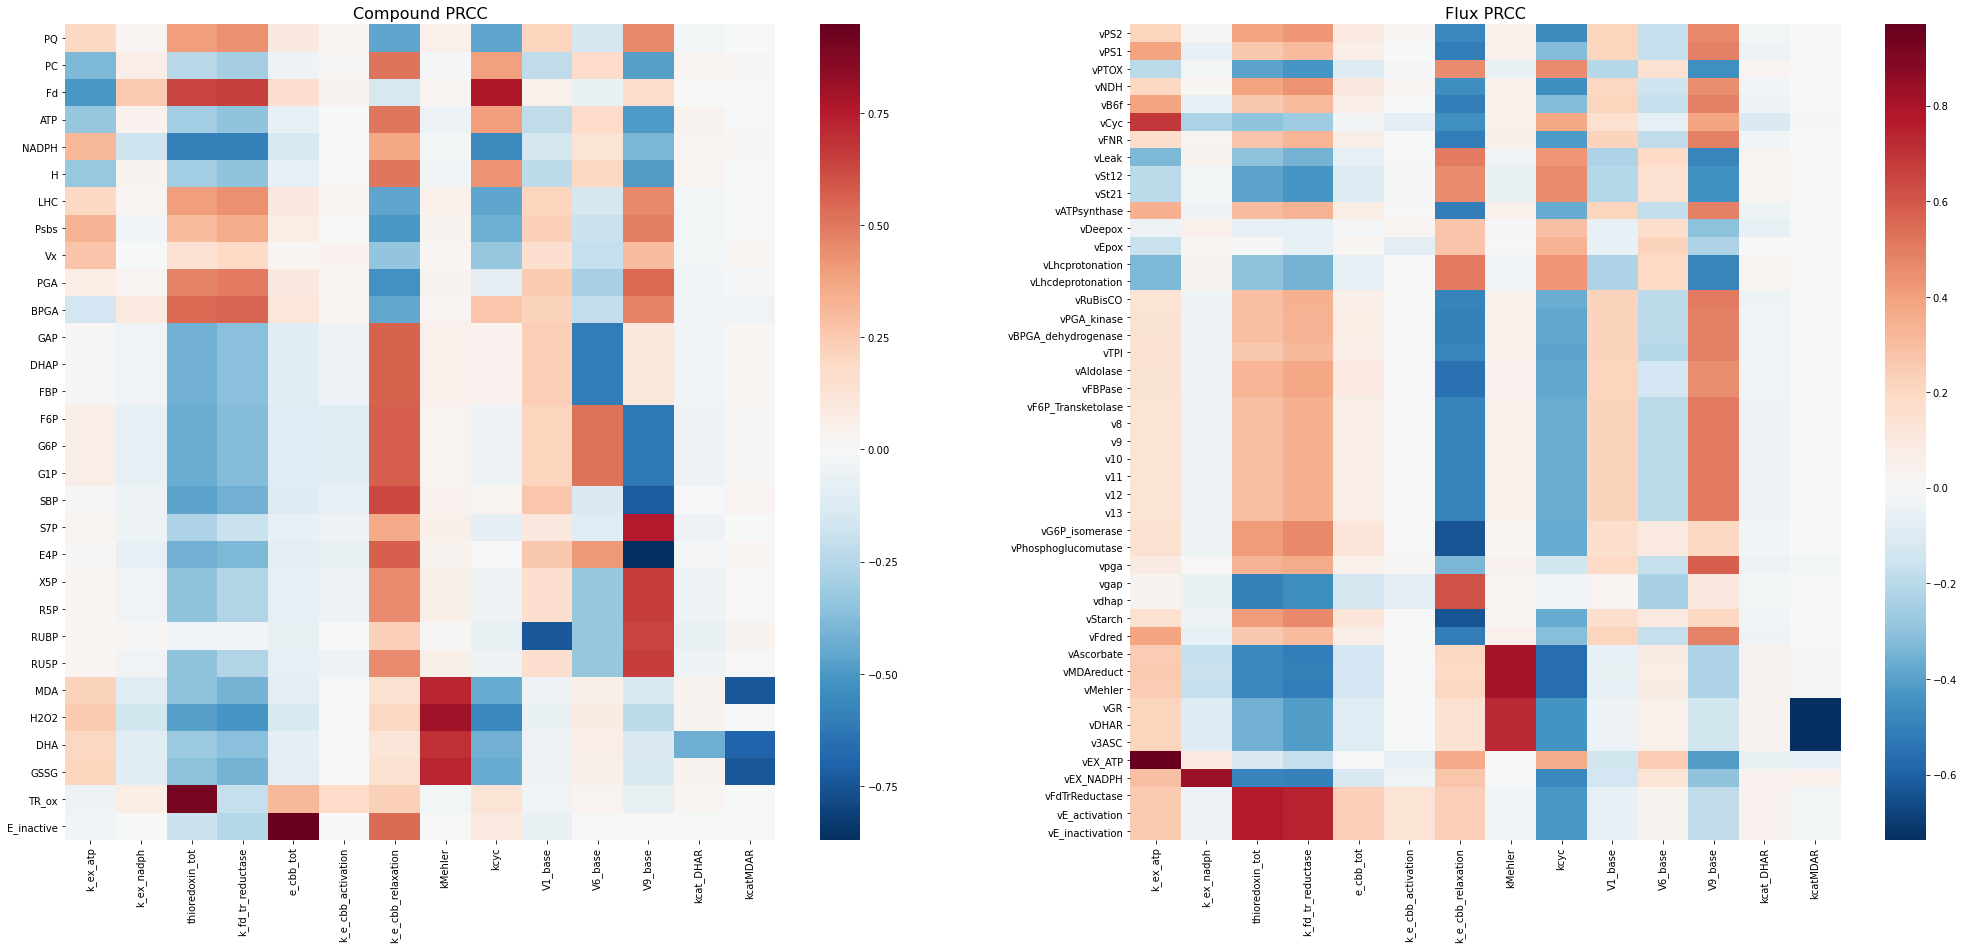

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(35, 15))
heatmap_from_dataframe(
    compound_prcc.loc[:, s.model.compounds].T,
    title="Compound PRCC",
    norm=TwoSlopeNorm(0),
    cmap="RdBu_r",
    ax=ax1,
    annotate=False,
)
heatmap_from_dataframe(
    flux_prcc.T,
    title="Flux PRCC",
    norm=TwoSlopeNorm(0),
    cmap="RdBu_r",
    ax=ax2,
    annotate=False,
)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
plt.show()